# Introduction
This notebook is part of the NRTK demonstration suite, demontstrating how perturbations can be applied and their impact measured via MAITE evaluation workflows.

## Layout
This notebook demonstrates how a particular condition (in this case, <b><i>extreme illumination conditions</i></b>), can affect an object detection model, and how that impact can be measured. The overall structure is:

- **Traditional vs. relative mAP:**
    - An overview of the nuances of what we'll be evaluating.
- **Setup:**
    - Notebook initialization, loading the supporting python code. Depending on if this is the first time you've run this notebook, this may take some time.
    - Loading the source image, which will be used throughout the notebook.
- **Image perturbation:**
    - The NRTK perturbation is demonstrated on the source image.
- **Baseline detections:**
    - The object detection model is loaded and run on the unperturbed image. These will serve as \"ground truth\" for comparisons against the perturbed images.
    - **Creating the test image set:**
        - The range of perturbations is defined and the test images are created.
        - Optionally, some or all of the perturbed images can be visualized.

At this point, we have the fundamental elements of our evaluation: the model, the test images, and the ground truth. Next we adapt these elements to be used with the MAITE evaluation workflow:
- **Wrapping the detection model**
- **Wrapping the images and detections into datasets**
- **Wrapping the metrics**

After the evaluation elements have been wrapped, we can run the evaluation:

- **Evaluation of perturbed images:**
    - The perturbed images (via the wrapped datasets) are run through MAITE's evaluation workflow, computing the mean average precision metric relative to the unperturbed detections.
- **Evaluation analysis:**
    - We plot and discuss the mAP@50 metric from each of the perturbed images, as well as per-class and per-area results.

# Evaluation guidance: traditional vs. relative mAP

This notebook will be evaluating the perturbed images using mean average precision (mAP) **relative** to detections from the unperturbed image. Traditional mAP scores the computed detections to ground-truth annotations vetted by an analyst; the mAP metric indicates how well the detector does compared to that analyst and thus measures the detector's "absolute" performance ("absolute" in the sense that the assumption is no detector can do better than the analyst.)

In contrast, in this notebook, we're not concerned with the **asbolute** ability of the detector to find objects of interest. Rather, we're interested in how the **perturbations** affect the detector *relative to the unperturbed image*. It's expected that the detector won't find every target in the unperturbed image; instead, we're measuring the **change in the detections** (or classifications) caused by the perturbations.

To support relative mAP, we'll be computing detections on the unperturbed image and using those as our "ground truth" dataset, and using the MAITE dataset class slightly differently than usual. For example, there's no on-disk json file of reference annotations with an associated data loader; instead, we'll be taking the computed dections and manually copying them over into the dataset.

# Setup: Notebook initialization
The next few cells import the python packages used in the rest of the notebook.

**Note:** We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that the first cell is **not** executed so that any related warnings are shown.

In [1]:
# warning suppression
import warnings
warnings.filterwarnings('ignore')

In [2]:
# package installation
import sys

print("Beginning package installation...")
!{sys.executable} -m pip install -qU pip

# some packages should be aggressively cleared
for package in ("nrtk", "opencv-python", "opencv-python-headless"):
    print(f'Uninstalling {package} (warnings about it not being installed are okay)...')
    !{sys.executable} -m pip uninstall -qy {package}
    
for package in ("nrtk", "matplotlib", "opencv-python-headless", "torchvision", "torchmetrics", "maite", "ultralytics"):
    print(f'Installing {package}...')
    !{sys.executable} -m pip install -q {package}

# some initial imports
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations
from matplotlib import pyplot as plt  # type: ignore
from matplotlib.axes import Axes  # type: ignore

import numpy as np
import os
import urllib.request

from typing import Any, Callable, Sequence
from PIL import Image
from nrtk.impls.perturb_image.generic.PIL.enhance import BrightnessPerturber
print("Done!")

Beginning package installation...
Uninstalling nrtk (warnings about it not being installed are okay)...
Uninstalling opencv-python (warnings about it not being installed are okay)...
Uninstalling opencv-python-headless (warnings about it not being installed are okay)...
Installing nrtk...
Installing matplotlib...
Installing opencv-python-headless...
Installing torchvision...
Installing torchmetrics...
Installing maite...
Installing ultralytics...
Done!


# Setup: Source image

In the next cell, we'll download and display a source image from the __[VisDrone](https://github.com/VisDrone/VisDrone-Dataset)__ dataset. The image will be cached in a local `data` subdirectory.

Note that when images are stored in `np.ndarray` objects, YOLO expects its images in [BGR](https://docs.ultralytics.com/modes/predict) channel order. NRTK expects and returns `np.ndarray` objects, which to avoid channel order confusion, we'll immedately convert back to PIL Image objects for storage.


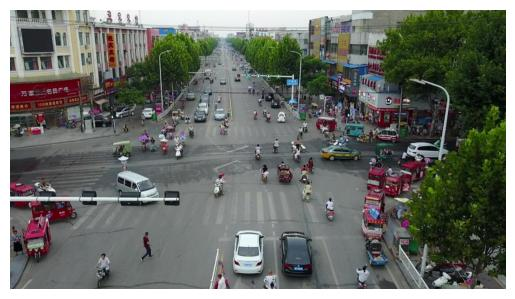

In [3]:
url = 'https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download'

data_dir = './data'
os.makedirs(data_dir, exist_ok=True)
img_path = os.path.join(data_dir, 'visdrone_img.jpg')
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)
    
# Keep a copy of the image in PIL format
img_pil = Image.open(img_path)
img_nd = np.asarray(img_pil)    # RGB channel order
plt.figure()
plt.axis('off')
_ = plt.imshow(img_nd)

# NRTK Brightness perturbation: examples and guidance

The Brightness perturbation is set by a single floating point value `f`:

- `f == 0.0` (the minimum value): returns a black image.
- `0.0 < f < 1.0`: returns an image dimmer than the original.
- `f == 1.0`: returns the original image unchanged.
- `f > 1.0`: returns an image brigher than the original. There is no upper bound, but values greater than 2 or 3 start to wash out objects in a typical image, as seen below.
  

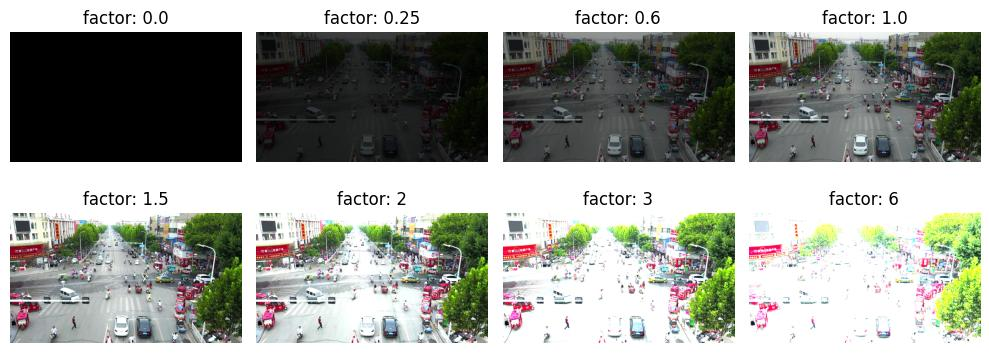

In [4]:
_, ax = plt.subplots(2,4,figsize=(10,4))
for idx, f in enumerate((0.0, 0.25, 0.6, 1.0, 1.5, 2, 3, 6)):
    (row, col) = (int(idx/4),idx%4)
    bp = BrightnessPerturber(factor = f)
    ax[row, col].set_title(f'factor: {f}') 
    ax[row, col].imshow( Image.fromarray(bp(img_nd)))
    _=ax[row, col].axis('off')
plt.tight_layout()

# Baseline detections

In the next cell, we'll download a [YOLOv11](https://docs.ultralytics.com/models/yolo11/) model, compute object detections on the source image, and display the results. As discussed above, these detections will serve as the "ground truth" for our relative mAP evaluation later.

Ultralytics 8.3.3 🚀 Python-3.8.10 torch-2.4.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16008MiB)
Setup complete ✅ (40 CPUs, 62.5 GB RAM, 842.8/914.7 GB disk)
Computing baseline...

0: 384x640 5 persons, 15 cars, 1 motorcycle, 2 trucks, 100.4ms
Speed: 8.6ms preprocess, 100.4ms inference, 206.0ms postprocess per image at shape (1, 3, 384, 640)


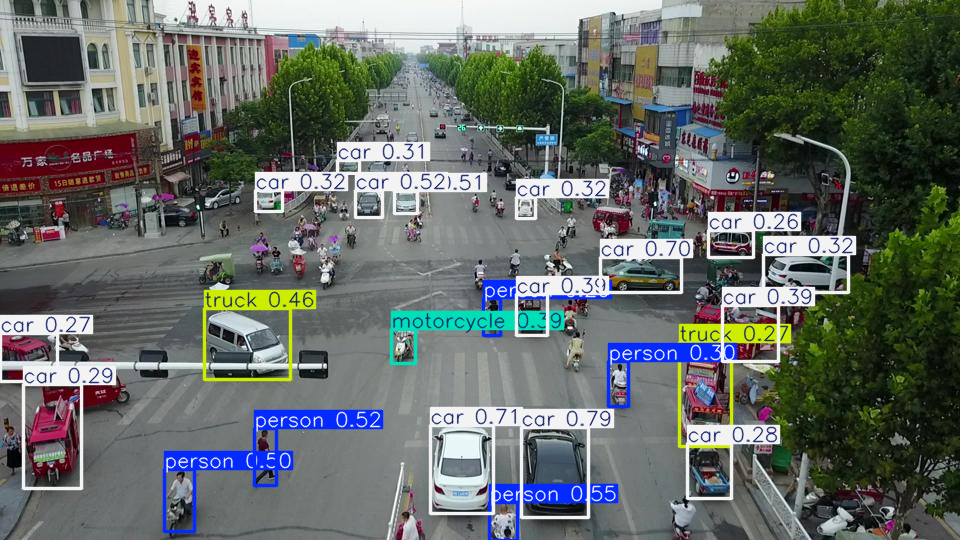

In [5]:
print('Importing YOLO support code...')
import ultralytics
ultralytics.checks()
print('Downloading model...')
model = ultralytics.YOLO('yolo11n.pt')
print('Computing baseline...')
baseline=model(img_pil)
baseline[0].show()

# NRTK Perturbation: test image set

Now we will generate a set of images with varying degrees of perturbation; these images will form the test set. In the cell below, you can set three parameters for sweeping the set of perturbation values:
- **sweep_low**: the minimum perturbation value (must be >= 0)
- **sweep_high**: the maximum perturbation value
- **sweep_count**: how many perturbations to generation

The cell then generates the perturbation values and perturbed image list.

In [6]:
SWEEP_LOW = 0.2
SWEEP_HIGH = 2.0
SWEEP_COUNT = 30

##
## end user-settable parameters
##
img_nd = np.asarray(img_pil)
perturbation_values = np.linspace(SWEEP_LOW, SWEEP_HIGH, SWEEP_COUNT, endpoint=True)
perturbation_images = list()
for p in perturbation_values:
    bp = BrightnessPerturber(factor = p)
    perturbation_images.append( Image.fromarray(bp(img_nd)))

print(f'Generated {len(perturbation_images)} test images')

Generated 30 test images


## Perturbed test image visualizations (optional)
The optional cell below lets you select test images to visualize. The images are selected by their index. To see the indices associated with the perturbation values, set `VISUALIZE_TEST_IMAGES` to `True` and `VISUALIZE_TEST_INDICES` to `[]` (empty.) Run the cell; the list of values and their indices will be printed. Enter the indices into `VISUALIZE_TEST_INDICES` (e.g. `[0,3,8]`) and re-run the cell.

To disable this cell (e.g. for a whole-notebook run), set `VISUALIZE_TEST_IMAGES` to `False`.

(This two-pass method avoids having to directly input the perturbation floating point values into the notebook as text, which can lead to problematic comparisons for equality.)

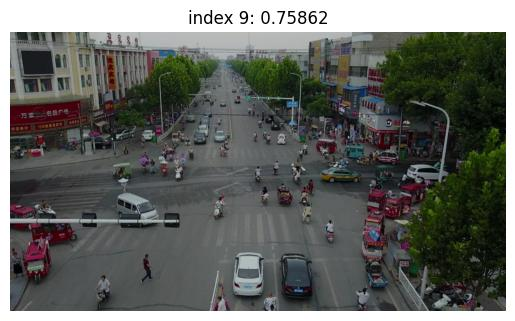

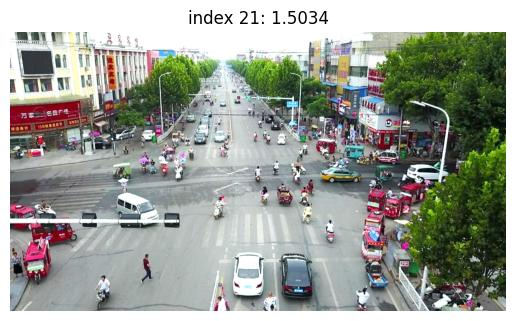

In [7]:
VISUALIZE_TEST_IMAGES = True
VISUALIZE_TEST_INDICES = [9,21]

##
## end user-settable parameters
##

if VISUALIZE_TEST_IMAGES:
 
    if len(VISUALIZE_TEST_INDICES) == 0:
        for idx, value in enumerate(perturbation_values):
            print(f'Index {idx}:  {value}')

    else:
        for idx in VISUALIZE_TEST_INDICES:
            value = perturbation_values[idx]
            fig, ax = plt.subplots()
            ax.set_title(f'index {idx}: {value:0.5}')
            ax.axis('off')
            ax.imshow(perturbation_images[idx])
else:
    print("Test image visualization disabled")

# Evaluating the NRTK perturbations with MAITE

We can now use [MAITE](https://jatic.pages.jatic.net/cdao/maite/index.html) to evaluate how the perturbations affect object detection. We'll be using the implementation of the mean average precision (mAP) metric from torchvision. The steps are:

- Adapting our experimental setup to the MAITE APIs, generally referred to as "wrapping":
    - Wrap the YOLO model in an adapter class that conforms to the [MAITE Object Detection Model](https://jatic.pages.jatic.net/cdao/maite/generated/maite.protocols.object_detection.Model.html) protocol
    - Wrap the detections and images together to form MAITE-compaitble datasets
    - Wrap the metrics in a MAITE-compatible metrics object
- Call MAITE's evaluation workflow on the wrapped objects
- Plot the results

## (1) Wrapping the detection model

The cell below defines a class wrapping the YOLO detection model in an adapter for the [MAITE Object Detection Model](https://jatic.pages.jatic.net/cdao/maite/generated/maite.protocols.object_detection.Model.html) protocol. The `__call__` method runs the model on images in the batch and is called by the MAITE evaluation workflow later in the notebook.

In [8]:
from maite.protocols import ArrayLike
from __future__ import annotations 

class MaiteYOLODetector:
    def __init__(self, model: ultralytics.models.yolo.model.YOLO):
        self._model = model

    def __call__(self, batch: Sequence[ArrayLike]) -> Sequence[YOLODetectionTarget]:
        yolo_predictions = self._model(batch, verbose=False)
        predictions = [
            YOLODetectionTarget(
                p.boxes.xyxy.cpu(),
                p.boxes.cls.cpu(),
                p.boxes.conf.cpu()
            )
            for p in yolo_predictions
        ]

        return predictions

# create the wrapped model object
yolo_model: od.Model = MaiteYOLODetector(model)

## (2) Wrapping images and detections into datasets

MAITE pairs images and their reference detections (aka targets, ground truth) into **datasets**. Typical ML workflows have many images per dataset, but in this notebook we have one dataset per perturbation, each with one image (the perturbed image) and the same reference detections (the baseline YOLO detections computed on the unperturbed source image.)

The following cell adds two classes to allow us to use YOLO detections with the MAITE evaluation workflow:

1. The `YOLODetectionTarget` helper class that stores the bounding boxes, label indices, and confidence scores for a single image's detections

2. The `MaiteYOLODetection` adapter class that conforms to the MAITE [Object Detection Dataset](https://jatic.pages.jatic.net/cdao/maite/generated/maite.protocols.object_detection.Dataset.html) protocol by providing the `__len__` and `__getitem__` methods. The returned item is a tuple of (image, `YOLODetectionTarget`, metadata-dictionary).

In [9]:
import torch
from dataclasses import dataclass

##
## Helper class for containing the boxes, label indices, and confidence scores.
##

@dataclass
class YOLODetectionTarget:
    boxes: torch.Tensor
    labels: torch.Tensor
    scores: torch.Tensor

##
## Wrap an image, its YOLO inference output, and a metadata dictionary
## in a MAITE Object Detection Dataset protocol-compliant class.
##

class MaiteYOLODetection:
    def __init__(self, img_pil: PIL.Image, yolo_result: ultralytics.engine.results.Results, metdata: dict[str, Any]):
        self._img_pil = img_pil
        self._result = yolo_result
        self._metadata = metadata

    def __len__(self) -> int:
        return 1

    def __getitem__(self, index:int) -> tuple[ArrayLike, YOLODetectionTarget, dict[str, Any]]:
        if index != 0:
            print('Index error: requested {}; can only be 0'.format(indx))
            raise IndexError

        boxes = self._result.boxes.xyxy.cpu()
        labels = self._result.boxes.cls.cpu() # these are floats
        scores = self._result.boxes.conf.cpu()

        return self._img_pil, YOLODetectionTarget( boxes, labels, scores), self._metadata

### Wrapping perturbed images into datasets

Our goal is to compute a separate set of metrics on each perturbed image, which will reflect how that degree of pertubation affects model performance. For this we'll need to wrap each perturbed image in its own dataset, which is slightly different than the usual ML workflow of a dataset containing many images whose overall performance is measured by a single metric.

The cell below creates the list of perturbed image datasets. Each perturbed image has the same 'ground truth' (the detections found in the unperturbed image).

If you'd like to visualize the model predictions for a given test image as its computed during evaluation, add its index to the `VISUALIZE_PREDICTION_INDICES` list.

In [10]:
##
## Set the VISUALIZE_PREDICTION_INDICES list to the indices of models whose predictions should be shown,
## similar to the VISUALIZE_TEST_INDICES list above.
##

# VISUALIZE_PREDICTION_INDICES = []  # empty: show none
# VISUALIZE_PREDICTION_INDICES = VISUALIZE_TEST_INDICES   # ...show predictions for each test image that was shown above
VISUALIZE_PREDICTION_INDICES = [3,9,24]    # ...or specify a completely independent set of images

##
## end user-settable parameters
##

perturbed_datasets = list()
for idx, v in enumerate(perturbation_values):
    metadata = {'perturbation': v, 'description': f'perturbation: {v}', 'visualize': idx in VISUALIZE_PREDICTION_INDICES }
    perturbed_datasets.append(
        MaiteYOLODetection( perturbation_images[idx], baseline[0], metadata )
    )


## (3) Wrapping the metrics

We'll compare the detections in the perturbed images to the unperturbed detections using the Mean Average Precision (mAP) metric from the `torchmetrics` package. The following cell creates a mAP metrics object, wraps it in a MAITE [MAITE Object Detection Metric](https://jatic.pages.jatic.net/cdao/maite/generated/maite.protocols.object_detection.Metric.html) protocol-compatible class, and then creates an instance of this class, which will be called by the `evaluate` workflow below.

This code is copied directly from the [MAITE object detection tutorial](https://jatic.pages.jatic.net/cdao/maite/tutorials/torchvision_object_detection.html#metrics) (with the exception of setting `class_metrics=True`.)

In [11]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

##
## Create an instance of the MAP metric object
##

tm_metric = MeanAveragePrecision(
    box_format="xyxy",
    iou_type="bbox",
    iou_thresholds=[0.5],
    rec_thresholds=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    max_detection_thresholds=[1, 10, 100],
    class_metrics=True,
    extended_summary=False,
    average="macro"
)

##
## This wrapper associates the MAP metric object with methods called by the evaluate
## workflow to accumulate detection data and compute the metrics. 
##

class WrappedTorchmetricsMetric:
    def __init__(
        self,
        tm_metric: Callable[
            [list[dict[str, torch.Tensor]], list[dict[str, torch.Tensor]]], dict[str, Any]]
    ):
        self._tm_metric = tm_metric

    # Create utility function to convert ObjectDetectionTarget_impl type to what
    # the type expected by torchmetrics IntersectionOverUnion metric
    @staticmethod
    def to_tensor_dict(target: od.ObjectDetectionTarget) -> dict[str, torch.Tensor]:
        """
        Convert an ObjectDetectionTarget_impl into a dictionary expected internally by
        raw `update` method of raw torchmetrics method
        """
        out = {
            "boxes": torch.as_tensor(target.boxes),
            "scores": torch.as_tensor(target.scores),
            "labels": torch.as_tensor(target.labels).type(torch.int64),
        }

        return out

    def update(self, preds: od.TargetBatchType, targets: od.TargetBatchType) -> None:
        # Convert to natively-typed from of preds/targets
        preds_tm = [self.to_tensor_dict(pred) for pred in preds]
        targets_tm = [self.to_tensor_dict(tgt) for tgt in targets]
        self._tm_metric.update(preds_tm, targets_tm)

    def compute(self) -> dict[str, Any]:
        return self._tm_metric.compute()

    def reset(self) -> None:
        self._tm_metric.reset()

##
## This is our instance variable that can compute the MAP metrics.
##

mAP_metric: od.Metric = WrappedTorchmetricsMetric(tm_metric)

### Evaluation sanity check: ground truth against itself

Here we quickly check the [evaluate](https://jatic.pages.jatic.net/cdao/maite/generated/maite.workflows.evaluate.html) workflow by creating a dataset from the source image and its baseline detections, and then running the source image through `evaluate`. The detections should be the same and thus give an mAP of 1.0.

In [12]:
from maite.workflows import evaluate

# create a dataset of the source image with its own detections as 'ground truth'
sanity_check_dataset: od.Dataset = MaiteYOLODetection( img_pil, baseline[0], {})

# call the model for each image in the dataset (in this case, just the source image),
# scoring the resulting detections against those from the dataset
sanity_check_results, _, _ = evaluate( model=yolo_model, dataset = sanity_check_dataset, metric = mAP_metric)

print('Sanity check: overall mAP (should be 1.0):', sanity_check_results['map'])

0it [00:00, ?it/s]

Sanity check: overall mAP (should be 1.0): tensor(1.)


# Evaluation of perturbed images

We now have all the wrappings required to evaluate the list of perturbed images:
- The `yolo_model` object, wrapping the YOLO model
- The `perturbed_datasets` list, containing a dataset for each perturbed image
- The `mAP_metrics` object, defining the metrics we wish to compute on each dataset

The next cell loops over each dataset, calling the `evaluate` workflow and accumulating the resulting metrics for subsequent analysis, and also plotting predictions for specific test images as requested above.

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

perturbation: 0.38620689655172413


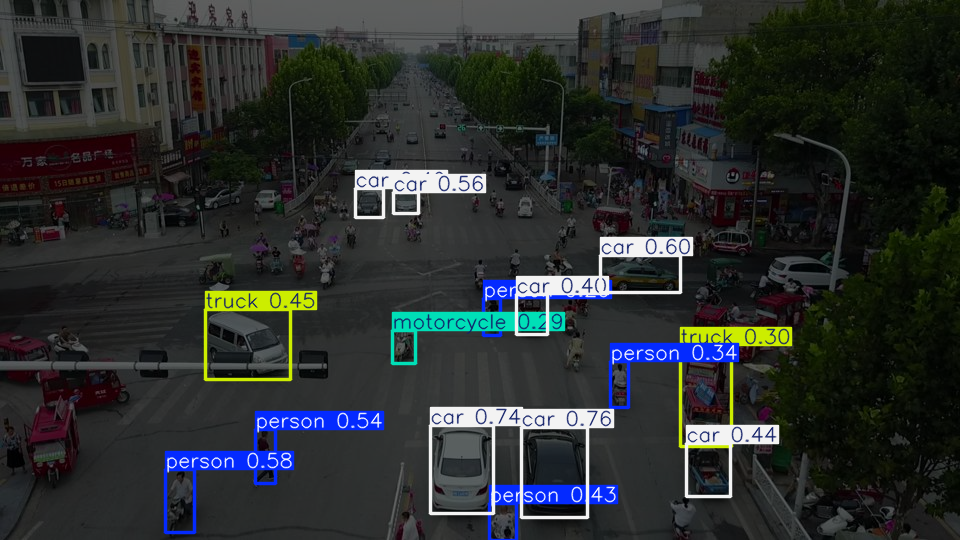

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

perturbation: 0.7586206896551724


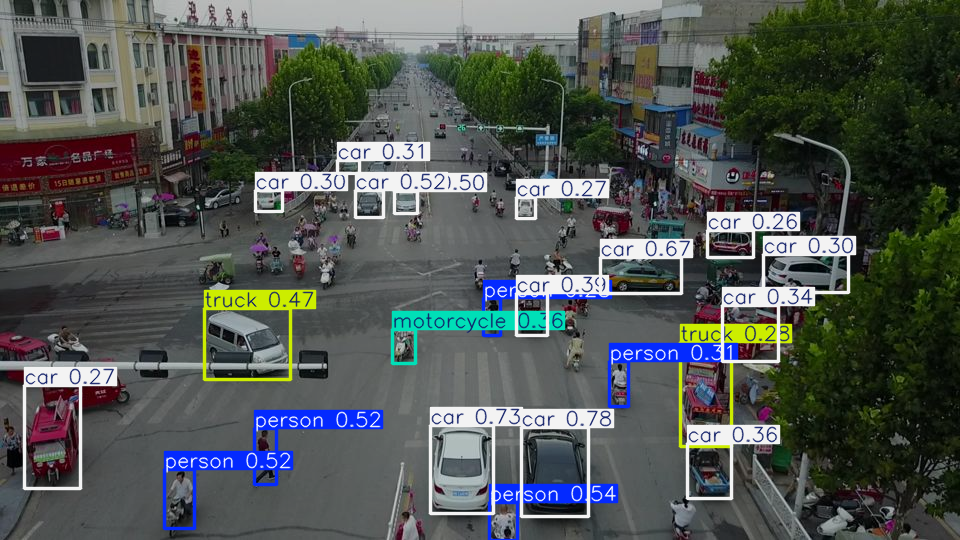

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

perturbation: 1.689655172413793


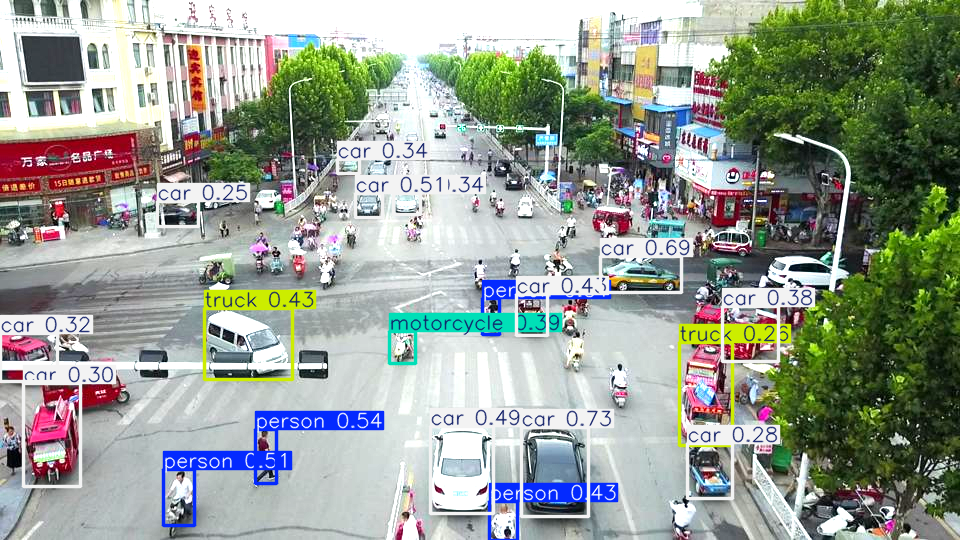

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [13]:
perturbed_metrics = list()
for ds in perturbed_datasets:
    # reset the metric object for each dataset
    mAP_metric.reset()
    result, _, _ = evaluate( model=yolo_model, dataset = ds, metric = mAP_metric)
    perturbed_metrics.append(result)
   
    # check dataset metadata to see if visualization is requested
    img, _, metadata = ds[0]
    if metadata['visualize']:
        # quickest way is to re-evaluate
        print(metadata['description'])
        _ = model(img)[0].show()
        

# Evaluation analysis

Now we can plot how the metrics (for example, mAP @ IoU=50) vary with perturbation level, keeping in mind this is a **relative** mAP against the detections in the unperturbed image.


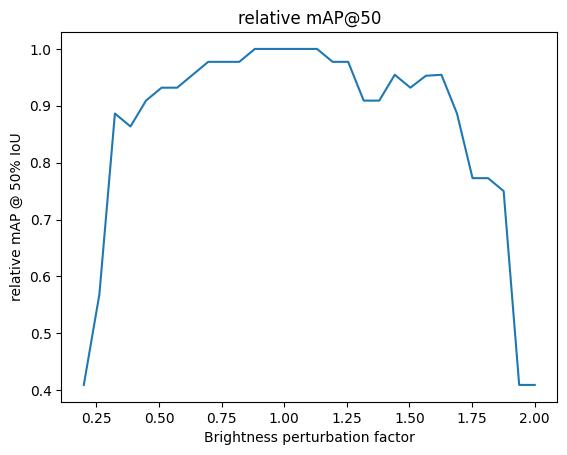

In [14]:
map50_list = [m['map_50'].item() for m in perturbed_metrics]
plt.title('relative mAP@50')
plt.xlabel('Brightness perturbation factor')
plt.ylabel('relative mAP @ 50% IoU')
_ = plt.plot(perturbation_values, map50_list)

## Evaluation interpretation

Note that as plotted, the minimum y-axis value is 0.4. The metric shown, mAP@50, is the average precision of detections across all classes when the bounding box IoU is at least 0.5 (for more details, [see here](https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html).) In general, we observe a perturbation value range between around 0.6 and 1.6 where the score is about 0.95 or higher, and sharp falloffs when the perturbation factor is below roughly 0.4 or above 1.75.  (Note the relative mAP is guaranteed to be 1.0 when the perturbation is 1.0, i.e. when the image is unchanged, the two detection sets are identical.)

## Additional plots

For further insight, we can plot the mAP per class:

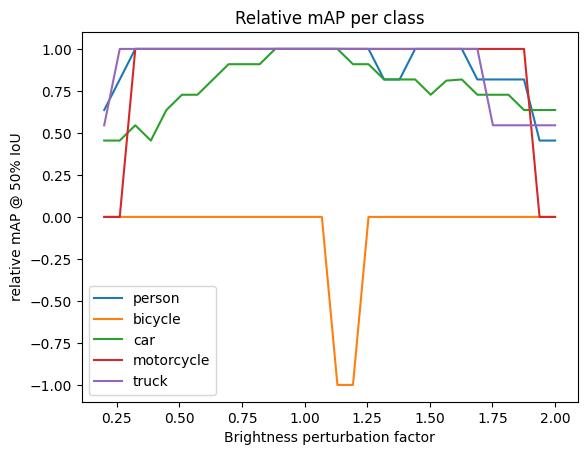

In [15]:
#
# Each instance of the metrics object has, potentially, a different set of observed classes.
# Loop through them to accumulate a unified set of classes to ensure consistent plotting across
# all thresholds.
#

unified_classes = set()
for m in perturbed_metrics:
    for class_idx in m['classes'].tolist():
        unified_classes.add(class_idx)

#
# dictionary of class_idx -> list of per-class mAP, or 0 if not present at that threshold
#

class_mAP = {class_idx: list() for class_idx in unified_classes}

#
# populate the lists across the perturbation values
#

for m in perturbed_metrics:
    this_perturbation_classes = m['classes'].tolist()
    for class_idx in unified_classes:
        if class_idx in this_perturbation_classes:
            # the index of the class in this individual metric instance
            this_class_idx = this_perturbation_classes.index(class_idx)
            class_mAP[class_idx].append( m['map_per_class'][this_class_idx].item())
        else:
            class_mAP[class_idx].append(0)

#
# plot
#

plt.title('Relative mAP per class')
plt.xlabel('Brightness perturbation factor')
plt.ylabel('relative mAP @ 50% IoU')
for (class_idx, class_mAP_list) in class_mAP.items():
    plt.plot(perturbation_values, class_mAP_list, label=baseline[0].names[class_idx] )
plt.legend()
plt.show()
    

This plot shows several interesting results:

- The only "false alarm" **class** (with a mAP value of -1) is the appearance of one or more bicycles around 1.24. There are no bicycles in the "ground truth" unperturbed detections (but again, since this a relative mAP, this does not necessarily mean there are no true bicycles in the image.)

- The truck, person, and motorcycle classes are much more robust to brightness perturbations than the car class. Examination of the unperturbed and a sample low-illumination image suggest a few possibilities:

    - There are many more car instances (15) than non-car (5 persons, 1 motorcycle, 2 trucks) in the unperturbed image.
    - The non-car classes detected in the unperturbed image are all in the foreground, and are thus larger. People, in particular, are distributed throughout the image, but only detected when relatively close and large.

Any conclusions about classification accuracy should be considered in light of these caveats. In particular, the foreground positioning of the detected non-car objects suggests that instead of looking at per-class results, we drill down by bounding box area. Fortunately, the metrics class supports this:


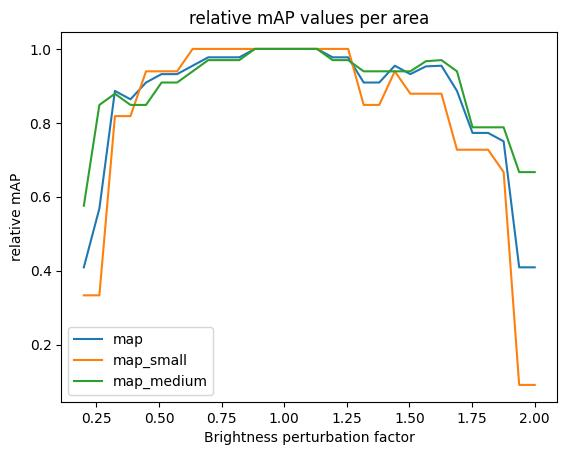

In [16]:
plt.title('relative mAP values per area')
plt.xlabel('Brightness perturbation factor')
plt.ylabel('relative mAP')
for k in ('map', 'map_small', 'map_medium'):
    plt.plot(perturbation_values, [m[k].item() for m in perturbed_metrics], label=k)
plt.legend()
plt.show()

The `map` line covers all sizes; `map_small` and `map_medium` are the mean average precision for objects (smaller than 32^2 pixels, between 32^2 and 96^2 pixels) in area, respectively. (Here, the mAP value is averaged over a **range** of IoU thresholds, betwee 0.5 and 0.95.) We see that medium objects, regardless of class, are generally much more robust to brighter illumination perturbations than small ones, which makes sense when observing how objects tend to get "washed out" in the perturbation examples shown in the [Examples and Guidance](#NRTK-Brightness-perturbation:-examples-and-guidance) section above. For dimming perturbations, the situation is reversed (although not as dramatically): small objects tend to be more robust than medium, but both fall off dramatically around 0.3.


# End of notebook